In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf

In [5]:
ticker = 'SAB.MC'

ini = dt.datetime(2012,12,31)
end = dt.datetime(2020,12,31)

data = web.DataReader(ticker, 'yahoo', ini, end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-12-31,1.442131,1.408795,1.442131,1.431260,4290347.0,1.139826
2013-01-02,1.466770,1.434884,1.455175,1.460248,8174228.0,1.162911
2013-01-03,1.472568,1.439232,1.453001,1.466770,4856891.0,1.168106
2013-01-04,1.477640,1.458799,1.466770,1.476916,5619984.0,1.176185
2013-01-07,1.506628,1.479090,1.481989,1.492859,8277467.0,1.188882
...,...,...,...,...,...,...
2020-12-24,0.372000,0.364400,0.364900,0.366400,27145723.0,0.366400
2020-12-28,0.377900,0.357500,0.375000,0.364800,32641653.0,0.364800
2020-12-29,0.368700,0.356500,0.366700,0.359300,40734140.0,0.359300


In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

historic = 120

x_train = []
y_train = []

for x in range(historic, len(scaled_data)):
    x_train.append(scaled_data[x-historic:x])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [15]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

['/device:CPU:0']

In [30]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
31/31 [==============================] - 9s 120ms/step - loss: 0.1181
Epoch 2/25
31/31 [==============================] - 4s 122ms/step - loss: 0.0090
Epoch 3/25
31/31 [==============================] - 4s 122ms/step - loss: 0.0057
Epoch 4/25
31/31 [==============================] - 4s 124ms/step - loss: 0.0055
Epoch 5/25
31/31 [==============================] - 4s 126ms/step - loss: 0.0053
Epoch 6/25
31/31 [==============================] - 4s 126ms/step - loss: 0.0050
Epoch 7/25
31/31 [==============================] - 4s 125ms/step - loss: 0.0050
Epoch 8/25
31/31 [==============================] - 4s 125ms/step - loss: 0.0048
Epoch 9/25
31/31 [==============================] - 4s 125ms/step - loss: 0.0052
Epoch 10/25
31/31 [==============================] - 4s 125ms/step - loss: 0.0040
Epoch 11/25
31/31 [==============================] - 4s 127ms/step - loss: 0.0045
Epoch 12/25
31/31 [==============================] - 4s 126ms/step - loss: 0.0045
Epoch 13/25
31/31 [======

In [31]:
test_ini = dt.datetime(2021,1,2)
test_end = dt.datetime.now()

test_data = web.DataReader(ticker, 'yahoo', test_ini, test_end)
actual_prices = test_data['Adj Close'].values

total_dataset = pd.concat((data['Adj Close'], test_data['Adj Close']), axis=0)

In [32]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - historic:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(historic, len(model_inputs)):
    x_test.append(model_inputs[x-historic:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

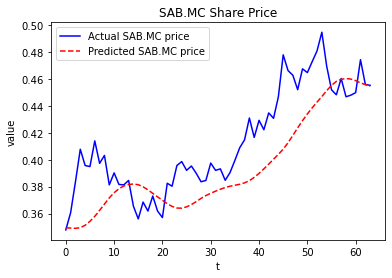

In [34]:
plt.plot(actual_prices, color='blue', label=f'Actual {ticker} price')
plt.plot(predicted_prices, color='red', linestyle='dashed', label=f'Predicted {ticker} price')
plt.title(f'{ticker} Share Price')
plt.xlabel('t')
plt.ylabel('value')
plt.legend()
plt.show()

In [79]:
# Lags and analytics

data['Shifted'] = data['Close'].shift(1)
data['var'] = (data['Close']-data['Shifted'])*100/data['Close']

ts = data.reset_index()[['Date','var']]

ts['month'] = ts['Date'].dt.strftime('%Y')+ts['Date'].dt.strftime('%m')
ts.drop('Date', axis = 1, inplace = True)
ts.drop(0, axis = 0, inplace = True)

ts['day'] = ts.groupby(['month']).cumcount()+1

ts

,var,month,day,nvar
1,1.985143,201301,1,0.593224
2,0.444655,201301,2,0.557926
3,0.686965,201301,3,0.563478
4,1.067954,201301,4,0.572208
5,0.048543,201301,5,0.548849
...,...,...,...,...
2041,1.664847,202012,18,0.585885
2042,-0.438596,202012,19,0.537687
2043,-1.530759,202012,20,0.512661
2044,0.498477,202012,21,0.559159


<AxesSubplot:xlabel='day', ylabel='var'>

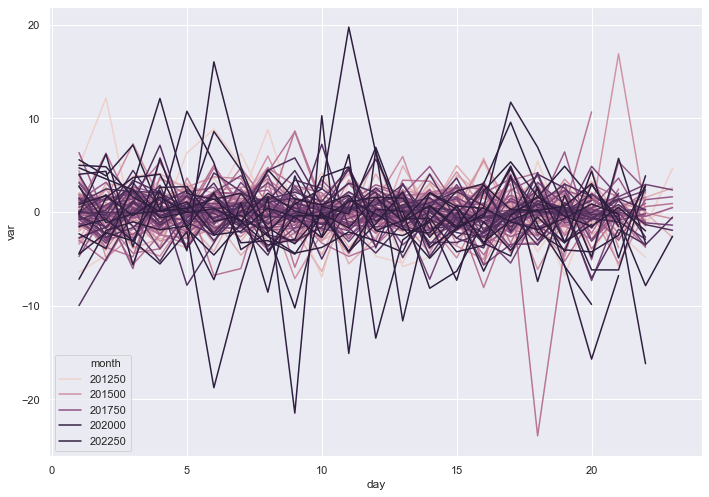

In [85]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(x='day', y='var', hue='month', data=ts)